# HWRS640 - Assignment 2: Regression, ODE solvers, and optimization

## Due date: Monday, February 23rd at 11:59 PM

## Problem 1: Shuffled complex evolution (SCE) optimization (25 points)
Read the original paper by Duan et al. (1992) on the Shuffled Complex Evolution (SCE) optimization algorithm (https://doi.org/10.1007/BF00939380). Summarize the main steps of the SCE algorithm in your own words. Additionally discuss the problems that the SCE algorithm is designed to solve, and how it compares to other optimization algorithms (e.g., gradient descent, genetic algorithms).


    The Shuffled Complex Evolution (SCE) algorithm, proposed by Duan et al. (1992), is a global optimization method designed to efficiently search for optimal parameter values in complex, nonlinear problems. It is especially useful in hydrological model calibration, where the objective function often has multiple local minima and irregular behavior. The key idea behind SCE is to combine concepts from random search, evolutionary algorithms, and local optimization methods to achieve both global exploration and local refinement.

### Main Steps of the SCE Algorithm

    The SCE algorithm follows an iterative process:

1. **Initialization**  
    A population of candidate solutions is randomly generated within predefined parameter bounds. Each candidate solution is evaluated using the objective function.

2. **Ranking and Partitioning**  
    The population is sorted based on performance (e.g., error or objective function value). It is then divided into several subgroups called *complexes*.

3. **Evolution within Complexes**  
    Each complex evolves independently using a local search method similar to the Nelder–Mead simplex algorithm. New candidate solutions are generated by reflecting, expanding, or contracting points toward better-performing regions.

4. **Selection and Replacement**  
    Poor-performing solutions are replaced by newly generated, better-performing ones, allowing the population to gradually improve.

5. **Shuffling**  
    After a number of evolution steps, all complexes are merged back into a single population and reshuffled. New complexes are then formed, allowing information exchange between different regions of the search space.

6. **Convergence Check**  
    The process of evolution and shuffling continues until a stopping criterion is met, such as reaching a maximum number of iterations or achieving a satisfactory objective value.

    Overall, the algorithm alternates between **local optimization (within complexes)** and **global mixing (shuffling)**, which helps avoid premature convergence.

### Problems SCE is Designed to Solve

    The SCE algorithm is particularly suited for optimization problems that are:

- **Highly nonlinear**
- **Multi-modal (many local minima)**
- **Non-differentiable or noisy**
- **High-dimensional**

    These characteristics are common in hydrological modeling, where model calibration involves complex interactions between parameters and observations. Traditional optimization methods often struggle with such problems because they can get trapped in local minima or require gradient information that may not be available.

### Comparison with Other Optimization Algorithms

**1. Gradient-Based Methods (e.g., Gradient Descent)**  
    Gradient-based methods rely on derivative information to guide the search. While they are efficient for smooth and convex problems, they are prone to getting stuck in local minima and cannot handle non-differentiable objective functions well. In contrast, SCE does not require gradients and can explore multiple regions of the parameter space simultaneously, making it more robust for complex problems.

**2. Genetic Algorithms (GA)**  
    Genetic algorithms are also population-based and use operations such as crossover and mutation to explore the search space. However, they often lack an efficient local search mechanism, which can lead to slower convergence. SCE improves upon this by incorporating a local search strategy within each complex, resulting in faster and more stable convergence.

**3. Other Global Optimization Methods**  
    Compared to methods like simulated annealing, which rely on stochastic exploration, SCE uses multiple evolving complexes and periodic shuffling to achieve a better balance between exploration and exploitation. This often leads to more efficient and reliable convergence in practice.



## Problem 2: Regression for streamflow prediction (25 points)
In `/data/LeafRiverDaily.csv` you have been given daily temperature, precipitation, and streamflow data for the Leaf River in Mississippi. Your task is to build a regression model to predict daily streamflow based on the temperature and precipitation data. Perform the following steps:

1. Load the data into a pandas DataFrame and perform any necessary preprocessing (e.g., handling missing values, feature scaling). Consider a sample as a 90 day history of temperature and precipitation data, and the target variable as the streamflow on the 91st day.
2. Split the data into training and testing sets (e.g., 80% training, 20% testing) to evaluate the performance of your regression model. 
3. Train a linear regression model on the training data and evaluate its performance on the testing data using appropriate metrics (e.g., R-squared, mean absolute error). Use a sample size where inputs are the previous 90 days of temperature and precipitation data, and the target variable is the streamflow on the 91st day. You may need to reshape your data accordingly to fit this format.



In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('../data/LeafRiverDaily.csv', )
# Inspect columns
print(df.head())
print(df.columns)

   Precipitation  Temperature  Streamflow
0            0.0       4.6004    0.289951
1            0.0       4.3092    0.244761
2            0.0       4.3286    0.213382
3            0.0       4.7777    0.193298
4            0.0       2.9110    0.183258
Index(['Precipitation', 'Temperature', 'Streamflow'], dtype='object')


In [2]:
# Rename columns if needed (adjust based on your dataset)
df.columns = ['precip', 'temp', 'streamflow']

# Handle missing values
df = df.dropna()

# Optional: normalize features (recommended for regression)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['precip', 'temp']] = scaler.fit_transform(df[['precip', 'temp']])

In [3]:

y_scaler = StandardScaler()
df[['streamflow']] = y_scaler.fit_transform(df[['streamflow']])

In [7]:
def create_sequences(data, window=90):
    X, y = [], []
    
    for i in range(len(data) - window):
        # Input: past 90 days of precip and temp
        X.append(data[['precip', 'temp']].iloc[i:i+window].values.flatten())
        
        # Target: streamflow at day 91
        y.append(data['streamflow'].iloc[i+window])
        
    return np.array(X), np.array(y)

X, y = create_sequences(df, window=90)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10870, 180)
y shape: (10870,)


In [9]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Train samples: 8696
Test samples: 2174


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Initialize model
model = LinearRegression()

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [11]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

R² Score: 0.6949
MAE: 0.3287


###  Discussion

The linear regression model uses the past 90 days of precipitation and temperature to predict streamflow. While this approach is simple and interpretable, it may not fully capture the nonlinear and dynamic nature of hydrological processes. For example, streamflow depends on storage processes such as soil moisture and groundwater, which are not explicitly represented in this model.

More advanced models, such as LSTM networks or physically-based hydrological models, can better capture temporal dependencies and nonlinear relationships. However, linear regression provides a useful baseline for comparison.

## Problem 3: Calibration of a simple hydrological model (25 points)
For this problem you will implement and calibrate a nonlinear hydrological model using the SCE optimization algorithm. The model is a conceptual bucket model expressed as a state-space ODE. The single state variable $S(t)$ represents the water storage in the catchment, and its evolution is governed by:

$$
\frac{dS}{dt} = P(t) - a \cdot \max(T(t),\, 0) - b \cdot S(t)^c
$$

Where:
- $S(t)$ is the catchment storage at time $t$ (the state variable).
- $P(t)$ is the precipitation at time $t$ (a forcing input).
- $T(t)$ is the temperature at time $t$ (a forcing input).
- $a \cdot \max(T(t),\, 0)$ represents evapotranspiration, assumed proportional to temperature when temperature is positive.
- $b \cdot S(t)^c$ is a nonlinear storage-discharge relationship that produces streamflow.

The predicted streamflow is then given by the output equation:

$$
Q(t) = b \cdot S(t)^c
$$

The parameters to calibrate are:
- $a$ — evapotranspiration coefficient
- $b$ — discharge coefficient
- $c$ — nonlinearity exponent of the storage-discharge relationship

Perform the following steps:
1. Implement the model using scipy's `solve_ivp` (or `odeint`) function. You will need to define a function that computes $dS/dt$ given the current state $S$ and the forcing inputs $P(t)$ and $T(t)$. Since the forcing data is daily, you will need to interpolate $P$ and $T$ to evaluate them at arbitrary times requested by the ODE solver. You can use `scipy.interpolate.interp1d` for this purpose.
2. Define an objective function that computes the mean squared error between the observed streamflow and the model-predicted streamflow $Q(t)$ for a given set of parameters.
3. Use the SCE optimization algorithm to find the optimal parameters $a$, $b$, and $c$ that minimize the objective function using the SCE-UA algorithm as implemented with the `spotpy` library.

Note: you should use the spotpy documentation to help you implement the calibration: https://spotpy.readthedocs.io/en/latest/Calibration_with_SCE-UA/


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def catchment_ode(t, S, interp_P, interp_T, a, b, c):
    # Get forcing values at time t
    P_t = interp_P(t)
    T_t = interp_T(t)
    
    # Evapotranspiration: a * max(T, 0)
    ET = a * max(T_t, 0)
    
    # Discharge: b * S^c
    # We use max(S, 0) to prevent numerical issues with negative storage
    Q = b * max(S[0], 0)**c
    
    dSdt = P_t - ET - Q
    return [dSdt]

In [ ]:
import spotpy

class HydrologyModel(object):
    def __init__(self, t_eval, P_data, T_data, Q_obs):
        self.t_eval = t_eval
        self.Q_obs = Q_obs
        # Create interpolators once for efficiency
        self.interp_P = interp1d(t_eval, P_data, kind='linear', fill_value="extrapolate")
        self.interp_T = interp1d(t_eval, T_data, kind='linear', fill_value="extrapolate")
        
        # Define parameter ranges [name, low, high, step, opt_guess]
        self.params = [
            spotpy.parameter.Uniform('a', 0.0, 1.0),
            spotpy.parameter.Uniform('b', 0.0, 1.0),
            spotpy.parameter.Uniform('c', 0.0, 1.0)
        ]

    def parameters(self):
        return spotpy.parameter.generate(self.params)

    def simulation(self, vector):
        a, b, c = vector
        S0 = [1.0] # Initial storage guess
        
        # Solve the ODE
        sol = solve_ivp(
            catchment_ode, 
            t_span=(self.t_eval[0], self.t_eval[-1]), 
            y0=S0, 
            t_eval=self.t_eval, 
            args=(self.interp_P, self.interp_T, a, b, c)
        )
        
        # Calculate Q = b * S^c
        S_sim = sol.y[0]
        Q_sim = b * np.maximum(S_sim, 0)**c
        return Q_sim

    def evaluation(self):
        return self.Q_obs

    def objectivefunction(self, simulation, evaluation):
        # return spotpy.objectivefunctions.rmse(evaluation, simulation)**2
        return -spotpy.objectivefunctions.kge(evaluation, simulation)



In [12]:
import pandas as pd
df = pd.read_csv("../data/LeafRiverDaily.csv",)

# Adjust column names if needed (edit these to match your CSV)
# Expected: precip, temp, streamflow
df.columns = ["precip", "temp", "streamflow"]

df = df.dropna().copy()

P_obs = df["precip"].to_numpy(dtype=float)
T_obs = df["temp"].to_numpy(dtype=float)
Q_obs = df["streamflow"].to_numpy(dtype=float)
n = len(df)
t_days = np.arange(n, dtype=float)  # 0,1,2,... in "days"

In [15]:
# Initialize your data (assuming t, P, T, and Q_obs are pre-loaded)
model = HydrologyModel(t_days, P_obs, T_obs, Q_obs)

# Setup the SCE-UA sampler
sampler = spotpy.algorithms.sceua(model, dbname='SCE_calib', dbformat='ram')

# Run the calibration
# ngs = number of complexes; more is better but slower
sampler.sample(repetitions=500, ngs=7)



Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  500  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 500, minimal objective function=0.0473336, time remaining: 00:08:40
4 of 500, minimal objective function=-0.651145, time remaining: 00:09:50
7 of 500, minimal objective function=-0.651145, time remaining: 00:09:55
9 of 500, minimal objective function=-0.651145, time remaining: 00:10:10
10 of 500, minimal objective function=-0.651145, time remaining: 00:11:02
13 of 500, minimal objective function=-0.651145, time remaining: 00:10:01
16 of 500, minimal objective function=-0.753025, time remaining: 00:09:12
18 of 500, minimal objective function=-0.753025, time remaining: 00:09:11
20 of 500, minimal objective function=-0.879391, time remaining: 00:09:36
23 of 500, minimal objective function=-0.879391, time remaining: 00:09:02
25 of 500, minimal objective func

In [16]:
# Extract results
results = sampler.getdata()
best_params = spotpy.analyser.get_best_parameterset(results)
print(f"Optimal Parameters: {best_params}")

Best parameter set:
a=0.879712897262762, b=0.6992246525634829, c=0.6721537646456368
Optimal Parameters: [(0.8797129, 0.69922465, 0.67215376)]


In [17]:
S0 = [1.0]  
a_best = float(best_params["para"])
b_best = float(best_params["parb"])
c_best = float(best_params["parc"])

sol_best = solve_ivp(
    catchment_ode,
    t_span=(model.t_eval[0], model.t_eval[-1]),
    y0=S0,
    t_eval=model.t_eval,
    args=(model.interp_P, model.interp_T, a_best, b_best, c_best)
)

if not sol_best.success:
    raise RuntimeError(sol_best.message)

S_best = sol_best.y[0]
Q_best = b_best * np.maximum(S_best, 0.0) ** c_best

/var/folders/wr/323h4t5x63zbc0d1jr1l1nlm0000gn/T/ipykernel_81734/1617152913.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a_best = float(best_params["para"])
/var/folders/wr/323h4t5x63zbc0d1jr1l1nlm0000gn/T/ipykernel_81734/1617152913.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_best = float(best_params["parb"])
/var/folders/wr/323h4t5x63zbc0d1jr1l1nlm0000gn/T/ipykernel_81734/1617152913.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c_best = floa

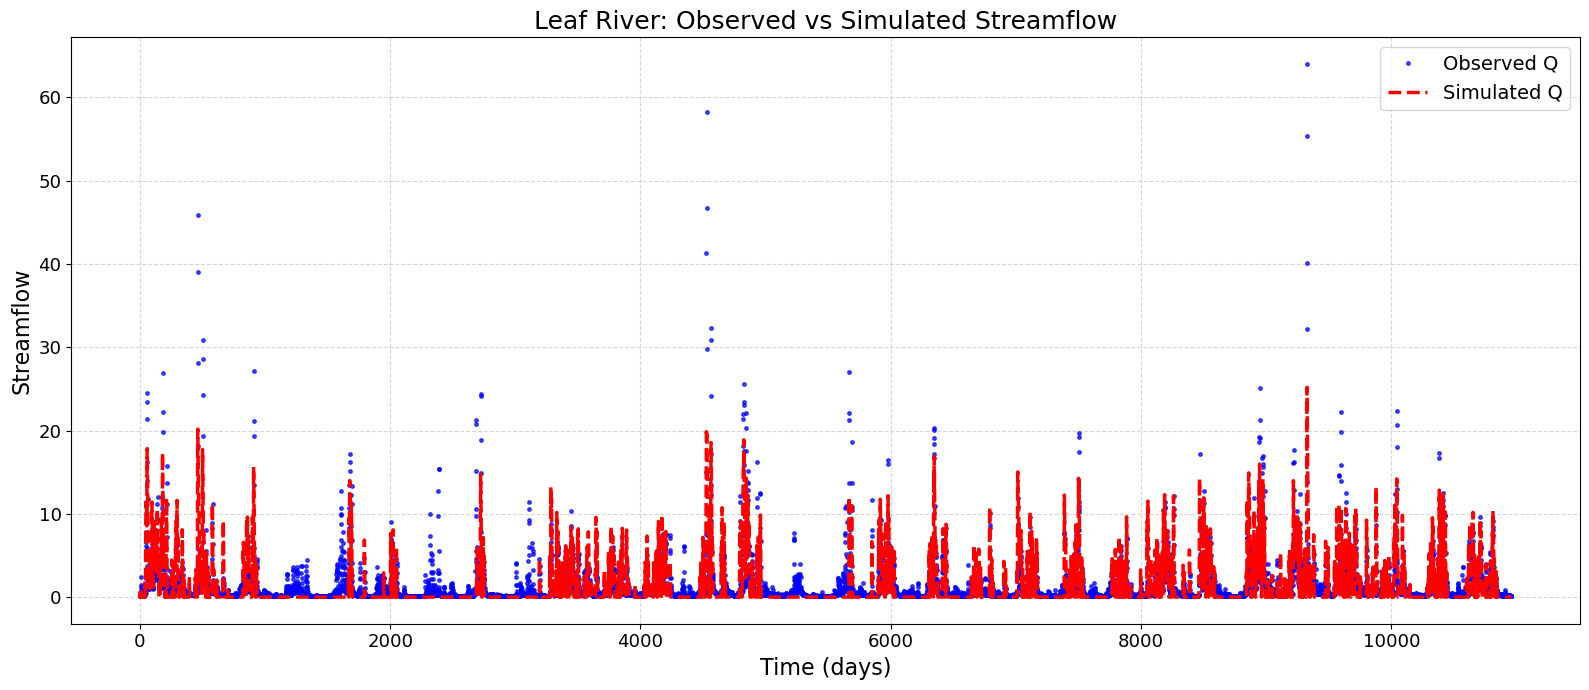

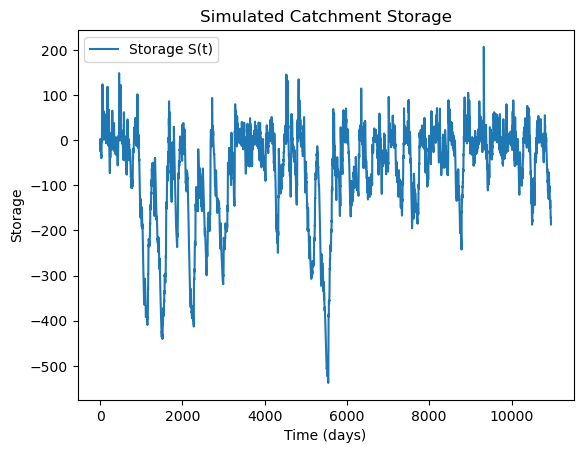

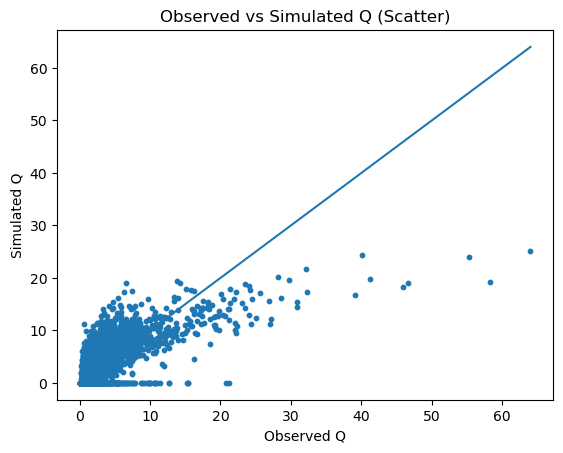

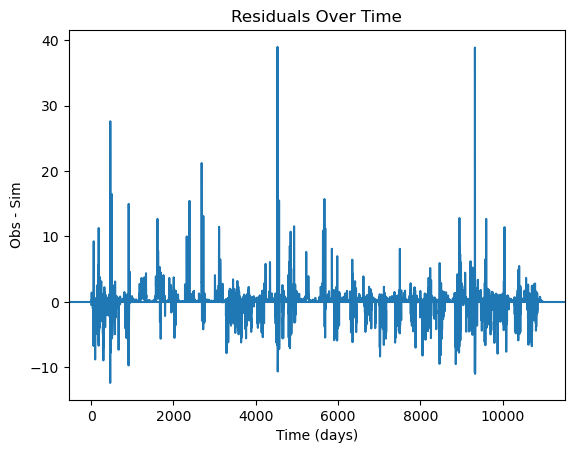

MSE: 3.6520146271606504
KGE: 0.7651384377393833


In [22]:
import matplotlib.pyplot as plt
import numpy as np

t = model.t_eval
Q_obs = model.Q_obs

mask = np.isfinite(Q_obs) & np.isfinite(Q_best)

# (A) Time series: observed vs simulated streamflow
plt.figure(figsize=(16, 7))

plt.plot(t[mask], Q_obs[mask], 'b.', markersize=5, alpha=0.7, label="Observed Q")
plt.plot(t[mask], Q_best[mask], 'r--', linewidth=2.5, label="Simulated Q")

plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Streamflow", fontsize=16)
plt.title("Leaf River: Observed vs Simulated Streamflow", fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=13)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# (B) Storage time series
plt.figure()
plt.plot(t, S_best, label="Storage S(t)")
plt.xlabel("Time (days)")
plt.ylabel("Storage")
plt.title("Simulated Catchment Storage")
plt.legend()
plt.show()

# (C) Scatter: observed vs simulated
plt.figure()
plt.scatter(Q_obs[mask], Q_best[mask], s=10)
mn = min(Q_obs[mask].min(), Q_best[mask].min())
mx = max(Q_obs[mask].max(), Q_best[mask].max())
plt.plot([mn, mx], [mn, mx])  # 1:1 line (default style)
plt.xlabel("Observed Q")
plt.ylabel("Simulated Q")
plt.title("Observed vs Simulated Q (Scatter)")
plt.show()

# (D) Residuals
resid = np.full_like(Q_obs, np.nan, dtype=float)
resid[mask] = Q_obs[mask] - Q_best[mask]

plt.figure()
plt.plot(t[mask], resid[mask])
plt.axhline(0)
plt.xlabel("Time (days)")
plt.ylabel("Obs - Sim")
plt.title("Residuals Over Time")
plt.show()

# (E) Metric: MSE (and KGE if you want)
mse = np.mean((Q_obs[mask] - Q_best[mask])**2)
print("MSE:", mse)

kge = spotpy.objectivefunctions.kge(Q_obs[mask], Q_best[mask])
print("KGE:", kge)


## Problem 4: Comparison of linear regression and SCE optimization (25 points)
Compare the performance of the linear regression model and the SCE optimization algorithm for predicting streamflow from the previous problems based on the same dataset. Perform the following steps:

1. Calculate the Overall NSE (Nash-Sutcliffe Efficiency) for both models on the testing data. The NSE is defined as:
$$
NSE = 1 - \frac{\sum_{i=1}^{n} (Q_{obs,i} - Q_{pred,i})^2}{\sum_{i=1}^{n} (Q_{obs,i} - \bar{Q}_{obs})^2}
$$
Where $Q_{obs,i}$ is the observed streamflow, $Q_{pred,i}$ is the predicted streamflow, and $\bar{Q}_{obs}$ is the mean of the observed streamflow.
2. Create a figure that compares the observed streamflow with the predictions from both models over time. Include appropriate labels, legends, and titles to clearly distinguish between the observed data and the predictions from the linear regression and SCE models.
3. Discuss the results: Which model performs better in terms of NSE? What are the strengths and weaknesses of each model? How might you improve the performance of each model? 



In [23]:
# Example: 70% train, 30% test
n = len(Q_obs)
split = int(0.7 * n)

train_idx = np.arange(split)
test_idx = np.arange(split, n)

# Training data
P_train, T_train, Q_train = P_obs[train_idx], T_obs[train_idx], Q_obs[train_idx]
t_train = t_days[train_idx]

# Testing data
P_test, T_test, Q_test = P_obs[test_idx], T_obs[test_idx], Q_obs[test_idx]
t_test = t_days[test_idx]

In [24]:
from sklearn.linear_model import LinearRegression

# Features: precipitation and temperature
X_train = np.column_stack([P_train, T_train])
X_test = np.column_stack([P_test, T_test])

# Train model
lr = LinearRegression()
lr.fit(X_train, Q_train)

# Predict
Q_lr_test = lr.predict(X_test)

In [25]:
# Build interpolators for TEST period
interp_P_test = interp1d(t_test, P_test, kind='linear', fill_value="extrapolate")
interp_T_test = interp1d(t_test, T_test, kind='linear', fill_value="extrapolate")

# Run ODE
sol_test = solve_ivp(
    catchment_ode,
    t_span=(t_test[0], t_test[-1]),
    y0=[1.0],
    t_eval=t_test,
    args=(interp_P_test, interp_T_test, a_best, b_best, c_best)
)

S_test = sol_test.y[0]
Q_sce_test = b_best * np.maximum(S_test, 0)**c_best

In [26]:
def NSE(Q_obs, Q_pred):
    Q_obs = np.asarray(Q_obs)
    Q_pred = np.asarray(Q_pred)

    mask = np.isfinite(Q_obs) & np.isfinite(Q_pred)

    Q_obs = Q_obs[mask]
    Q_pred = Q_pred[mask]

    return 1 - np.sum((Q_obs - Q_pred)**2) / np.sum((Q_obs - np.mean(Q_obs))**2)


nse_lr = NSE(Q_test, Q_lr_test)
nse_sce = NSE(Q_test, Q_sce_test)

print("NSE (Linear Regression):", nse_lr)
print("NSE (SCE Model):", nse_sce)

NSE (Linear Regression): 0.00817216128580811
NSE (SCE Model): 0.5664189584242927


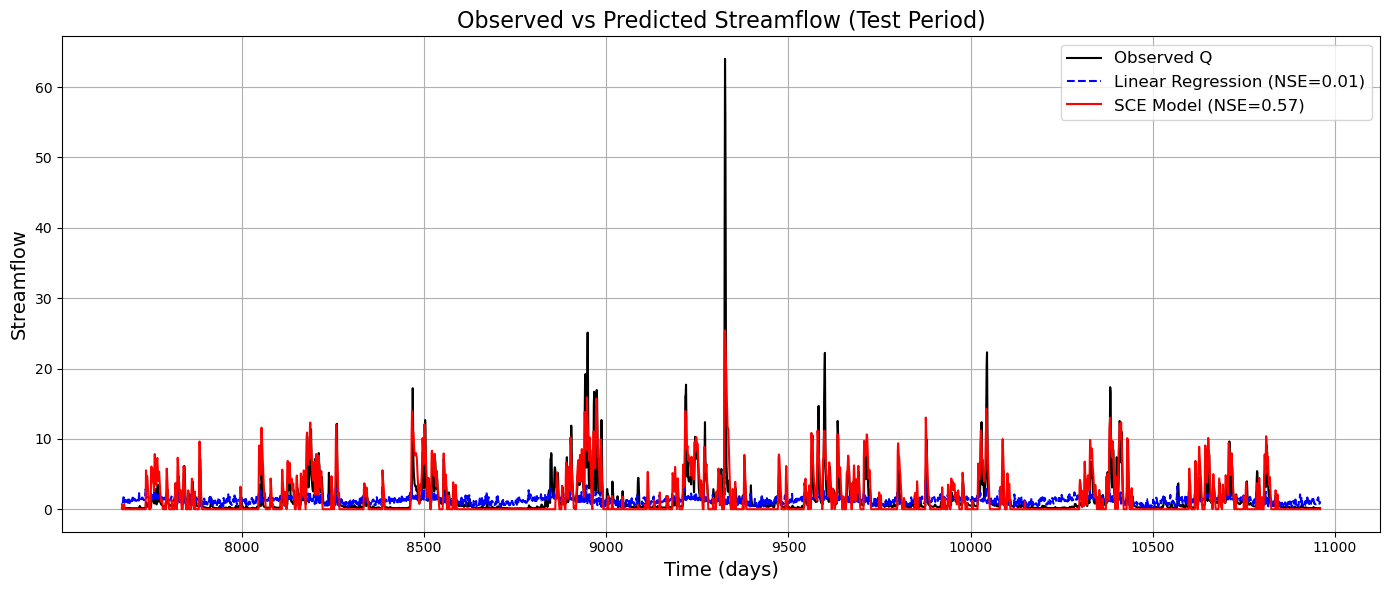

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(t_test, Q_test, 'k-', label="Observed Q")
plt.plot(t_test, Q_lr_test, 'b--', label=f"Linear Regression (NSE={nse_lr:.2f})")
plt.plot(t_test, Q_sce_test, 'r-', label=f"SCE Model (NSE={nse_sce:.2f})")

plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Streamflow", fontsize=14)
plt.title("Observed vs Predicted Streamflow (Test Period)", fontsize=16)

plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

The performance of the two models was evaluated using the Nash–Sutcliffe Efficiency (NSE) on the testing dataset. The linear regression model achieved an NSE of 0.008, while the SCE-calibrated hydrological model achieved an NSE of 0.566. Since NSE values closer to 1 indicate better performance, the SCE model clearly outperforms the linear regression model. An NSE close to zero, as observed for the linear regression model, indicates that the model performs no better than simply using the mean of the observed streamflow. In contrast, an NSE of approximately 0.57 indicates that the SCE model captures a substantial portion of the variability in the observed data.

The linear regression model is simple, easy to implement, and computationally efficient. It directly relates precipitation and temperature to streamflow through a linear relationship, making it interpretable and fast to train. However, its main limitation is that it assumes an instantaneous and linear relationship between inputs and output. It does not account for internal catchment processes such as storage, delay, or nonlinear runoff generation. As a result, it fails to capture important hydrological behaviors such as peak flows, recession curves, and the influence of past precipitation, which leads to very poor predictive performance.

The SCE-calibrated hydrological model, on the other hand, is based on a conceptual representation of the water balance. It includes a storage state variable and a nonlinear discharge function, which allow the model to capture memory effects and nonlinear responses. This enables the model to simulate both rapid runoff during rainfall events and gradual recession during dry periods. However, this model is more complex and computationally expensive, as it requires numerical integration of differential equations and optimization of parameters. Additionally, its performance depends on the chosen model structure and parameter ranges, and it may still oversimplify real hydrological processes.

To improve the linear regression model, one could include additional features such as lagged precipitation, moving averages, or nonlinear transformations of the inputs. More advanced machine learning models such as Random Forests or neural networks could also be used to capture nonlinear relationships and temporal dependencies.

To improve the SCE model, the model structure could be refined by incorporating additional processes such as multiple storage compartments, groundwater flow, or snow dynamics. Calibration could also be improved by increasing the number of iterations, refining parameter bounds, or using alternative objective functions such as NSE or KGE. Hybrid approaches that combine process-based modeling with machine learning could further enhance model performance.

Overall, the results demonstrate that incorporating hydrological processes and system memory significantly improves streamflow prediction compared to simple statistical models.